In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import geopandas as gpd
import rasterio
import osmnx as ox
import json
import geojson

import cv2
import random

from shapely.geometry import LineString, CAP_STYLE
from shapely.ops import transform
from shapely import wkt
import shapely.geometry as gm

from skimage import measure, morphology
from rasterio import features as raster_features
from rasterio.plot import show
from rasterio.enums import MergeAlg

from bng_latlon import OSGB36toWGS84
from geojson import Polygon, Feature, FeatureCollection

In [2]:
min_height = 5.2
width = 10

DTM = 'DTM.tif'
DSM = 'DSM.tif'

In [3]:
voltages = {
    'ESO': {
        'Voltages': ['275kV', '400kV'],
        'MinHeight': [5.2, 5.2],
        'Company': 'National Grid',
        'SafeHoriziontalDistance': [10, 10],
        'Priority': 0.7
    },
    'DNO': {
        'Voltages': ['132kV','33kV', '11kV'],
        'MinHeight': [5.2, 5.2, 5.2],
        'Company': 'Northern Power',
        'SafeHoriziontalDistance': [10, 10, 10],
        'Priority': 0.5
    }
}

#https://www.hse.gov.uk/pubns/ais8.pdf

In [4]:
raster = rasterio.open(DTM)

In [5]:
## bbox - top left, top right, bottom left, bottom right
bbox = [[raster.bounds.left, raster.bounds.top], [raster.bounds.right, raster.bounds.top], 
        [raster.bounds.left, raster.bounds.bottom], [raster.bounds.right, raster.bounds.bottom]]

bbox_wsg84 = []
for x in bbox:
    x, y = OSGB36toWGS84(x[0], x[1])
    bbox_wsg84.append([x, y])

left = bbox_wsg84[2][1]
right = bbox_wsg84[1][1]
bottom = bbox_wsg84[3][0]
top = bbox_wsg84[0][0]

In [6]:
with open('DNO-Network.geojson') as f:
    dno = geojson.load(f)
with open('ESO-Cabel.geojson') as f:
    eso_cable = geojson.load(f)
with open('ESO-OHL.geojson') as f:
    eso_ohl = geojson.load(f)

for x in dno['features']:
    x['properties']['network'] = 'DNO'
    x['properties']['stroke'] = '#40bf40'
    x['properties']['stroke-opacity'] = 0.5
    x['properties']['priority'] = voltages[x['properties']['network']]['Priority']

for x in eso_cable['features']:
    x['properties']['network'] = 'ESO'
    x['properties']['stroke'] = '#6c936c'
    x['properties']['stroke-opacity'] = 0.3
    x['properties']['priority'] = 0.1

for x in eso_ohl['features']:
    x['properties']['network'] = 'ESO'
    x['properties']['stroke'] = '#00ff00'
    x['properties']['stroke-opacity'] = 0.7
    x['properties']['priority'] = voltages[x['properties']['network']]['Priority']




fs = dno['features'] + eso_cable['features'] + eso_ohl['features']

feature_collection = FeatureCollection(fs)
with open('NE-power-network.geojson', 'w') as f:
   json.dump(feature_collection, f)

In [7]:
edges = gpd.read_file('NE-power-network.geojson', driver='GeoJSON')
edges = edges.cx[left:right, bottom:top]
edges.to_file('NE-power-network-trimmed.geojson', driver='GeoJSON')


In [8]:
edges_osgb = edges.to_crs(raster.crs)
geom = [(shapes.buffer(width, cap_style=CAP_STYLE.round), value) for shapes, value in zip(edges_osgb.geometry, edges_osgb.priority)]

# geom = ([shapes.buffer(width, cap_style=CAP_STYLE.round) for shapes in edges_osgb.geometry])

In [9]:
rasterized = raster_features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 0,
                                dtype = None)


In [10]:
with rasterio.open(DTM) as dtm:
    lidar_dtm = dtm.read(1)
with rasterio.open(DSM) as dsm:
    lidar_dsm = dsm.read(1)

CHM = lidar_dsm - lidar_dtm

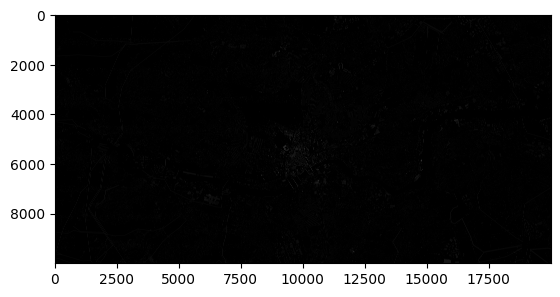

In [11]:
overlay = CHM.copy()
network = rasterized > 0
overlay[network] = [10]

plt.imshow(overlay, cmap='gray')

In [12]:
trigger = (CHM > min_height).astype(int)
combined = np.add(rasterized, trigger)
combined_mask = combined > 1


In [13]:
blank = np.zeros(combined_mask.shape)
blank[combined_mask] = [1]

In [14]:
image = overlay.copy()
img = np.uint8(blank.copy())

ret2,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# find the contours
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print("Number of contours detected:",len(contours))
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for cnt in contours:
   approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
   (x,y)=cnt[0,0]

   if len(approx) >= 1:
      image = cv2.drawContours(image, [approx], -1, (255, 0, 0), 10)
# cv2.imshow("Polygon", cv2.resize(image, (1000, 1000)))

cv2.imwrite("polygon.png", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Number of contours detected: 4828


True

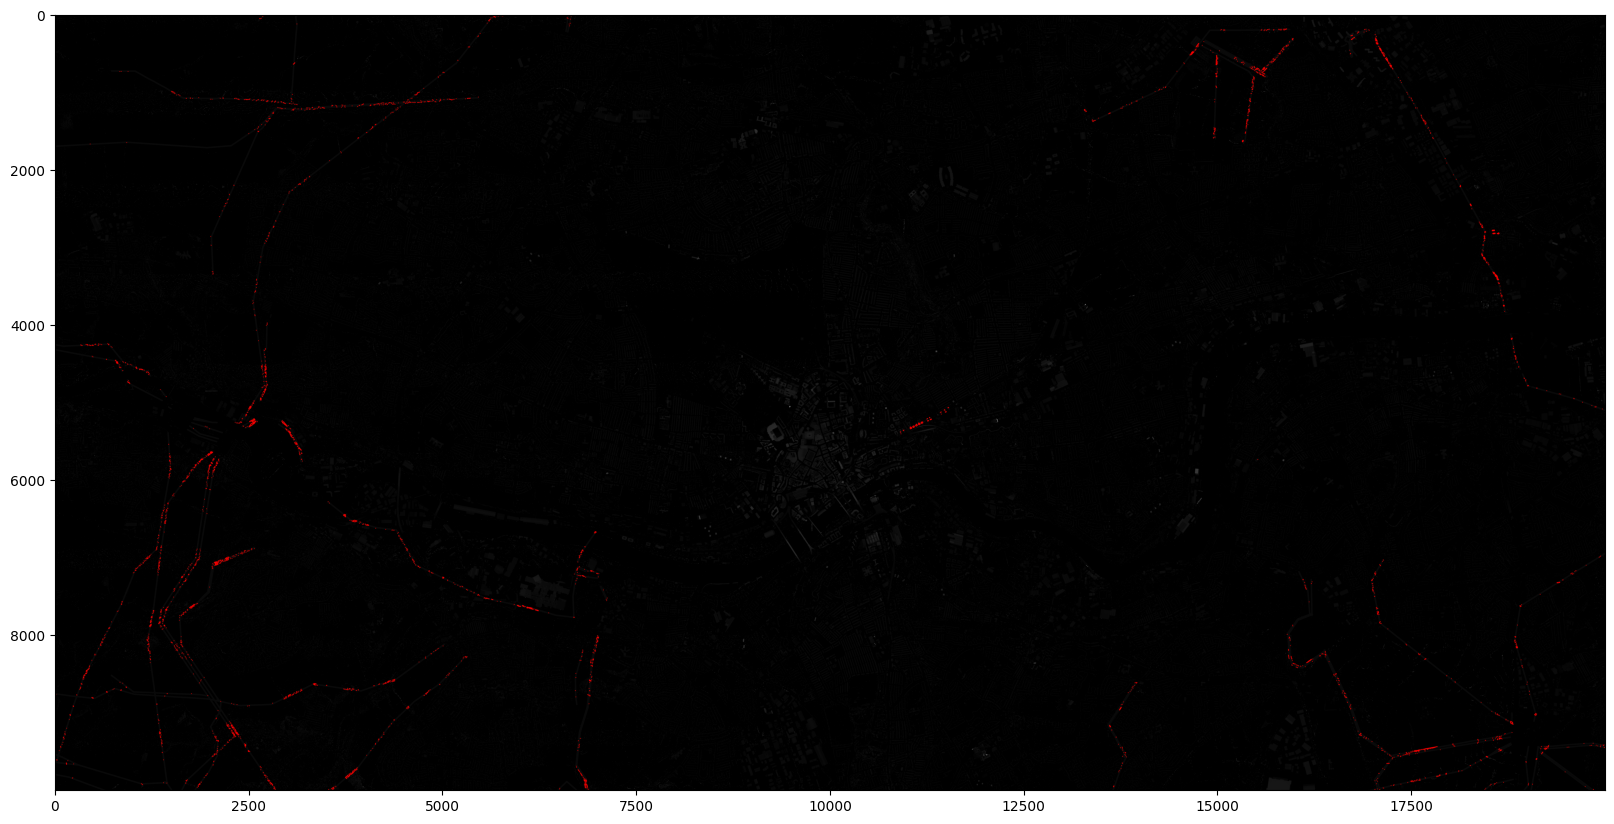

In [15]:
plt.figure(figsize = (20,20))
plt.imshow(image)
# plt.imshow(image[4000:5000, 0:1000])

In [16]:
big_contours = []
for contour in contours:
    if len(contour) > 3:
        big_contours.append(contour)

In [17]:
fc = []
for indx, t in enumerate(big_contours):
    polygon = []
    polygon_image = []
    first = True
    for b in t:
        x, y = OSGB36toWGS84(b[0][0]+raster.bounds.left, raster.bounds.top - b[0][1])
        polygon.append((y, x))
        if first:
            x_1, y_1 = OSGB36toWGS84(b[0][0]+raster.bounds.left, raster.bounds.top - b[0][1])
            first = False
    polygon.append((y_1, x_1))
    mypolygon = Polygon([polygon])
    centroid = (gm.Polygon(polygon).centroid.coords.xy[1][0], gm.Polygon(polygon).centroid.coords.xy[0][0])

    first = True
    for b in t:
        x, y = (b[0][0], b[0][1])
        polygon_image.append((y, x))
        if first:
            x_1_image, y_1_image = (b[0][0], b[0][1])
            first = False
    polygon_image.append((y_1_image, x_1_image))
    mypolygon_image = Polygon([polygon_image])
    centroid_image = (gm.Polygon(polygon_image).centroid.coords.xy[1][0], gm.Polygon(polygon_image).centroid.coords.xy[0][0])

    image_values = []
    for element in polygon_image:
        image_values.append(combined[element[0], element[1]])

    priority_value = max(image_values)-1
    if priority_value < 0:
        priority_value = 0
    
    if priority_value > 0.6:
        stroke_val = '#ff0000'
        priority_val = 'High'
    elif priority_value > 0.3:
        stroke_val = '#ff8000'
        priority_val = 'Medium'
    elif priority_value > 0:
        stroke_val = '#ffff00'
        priority_val = 'Low'
    else:
        stroke_val = '#000000'
        priority_val = 'N/A'
    
    weighted_val = priority_value * gm.Polygon(polygon).area*1000000

    if weighted_val > 0.02:
        fill_val = '#ff0000'
        rank_group = 'Very High'
    elif weighted_val > 0.01:
        fill_val = '#ff8000'
        rank_group = 'High'
    elif priority_value > 0.005:
        fill_val = '#ffff00'
        rank_group = 'Medium'
    else:
        fill_val = '#bfff00'
        rank_group = 'Low'
    


    props = {
        "priority group": rank_group,
        "line priority": priority_val,
        "weighted_value": weighted_val,
        "stroke": stroke_val,
        "stroke-width": 3,
        "stroke-opacity": 1,
        "fill": fill_val,
        "fill-opacity": 0.75,
        "id": indx+1,
        "centroid": centroid
    }

    my_feature = Feature(geometry=mypolygon, properties=props)
    if gm.Polygon(polygon).area*1000000 != 0:
        fc.append(my_feature)



In [18]:
fc.sort(key=lambda x: x["properties"]["weighted_value"], reverse=True)

In [19]:
from geopy.geocoders import Nominatim
def get_address(x,y):
    geolocator = Nominatim(user_agent="geoapiExercises")
    response = geolocator.reverse([x, y])
    if response:
        return (response.address)
    else:
        return ("Error")

In [20]:
for i, q in enumerate(fc):
    q['properties']['Rank'] = i+1
    # if q['properties']['centroid'] != (128.0, -4.0):
    q['properties']['closest address'] = get_address(q['properties']['centroid'][0], q['properties']['centroid'][1])
    # q['properties']['closest address'] = ''
    # else:
    #     q['properties']['closest address'] = ''
    print(f"{i}/{len(fc)} - {q['properties']['centroid'][0], q['properties']['centroid'][1]} - {q['properties']['closest address']}")

0/634 - (54.976763356028286, -1.7275473283207492) - Maynards Travel, 10, Shelley Road, Newburn Industrial Estate, Lemington, Newburn, Newcastle upon Tyne, North of Tyne, England, NE15 9RT, United Kingdom
1/634 - (54.96551153619852, -1.7068713291381448) - Chainbridge Road-Railway Crossing, Chainbridge Road, Blaydon Industrial Park, Blaydon on Tyne, Gateshead, Tyne and Wear, North East, England, NE21 5ST, United Kingdom
2/634 - (54.97687464570353, -1.7210050141887472) - Riversdale Way, Lemington, Blucher, Newcastle upon Tyne, North of Tyne, England, NE15 8SG, United Kingdom
3/634 - (54.94134645959366, -1.474016078170769) - A19, Boldon Colliery, South Tyneside, Tyne and Wear, North East, England, NE36 0BG, United Kingdom
4/634 - (54.99521800498825, -1.4788086266013496) - Howdon Road, Percy Main, North Shields, North Tyneside, North of Tyne, England, NE29 6JW, United Kingdom
5/634 - (54.9773219495509, -1.7270458121616052) - Lemington, Newburn, Newcastle upon Tyne, North of Tyne, England, N

In [21]:
feature_collection = FeatureCollection(fc)

with open('analysis.geojson', 'w') as f:
   json.dump(feature_collection, f)
